# Computing saliency masks with the PAIRML saliency library

This notebook demonstrates a number of saliency mask techniques, augmented with the `SmoothGrad` technique, using the Inception V3 convolutional neural network. The intention of this notebook is to have as few dependencies as possible to show how to compute masks.

This notebook shows the following techniques, alongside with the `SmoothGrad` augmentation:

*   Vanilla Gradients
    ([paper](https://scholar.google.com/scholar?q=Visualizing+higher-layer+features+of+a+deep+network&btnG=&hl=en&as_sdt=0%2C22),
    [paper](https://arxiv.org/abs/1312.6034))
*   Guided Backpropogation ([paper](https://arxiv.org/abs/1412.6806))
*   Integrated Gradients ([paper](https://arxiv.org/abs/1703.01365))
*   Occlusion

This notebook assumes you have the `saliency` pip package installed. To install run (use `pip3` for python 3.x):
```
pip install saliency
```

In [134]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P
import pickle
import random
import os
slim=tf.contrib.slim

if not os.path.exists('models/research/slim'):
  !git clone https://github.com/tensorflow/models/
old_cwd = os.getcwd()
os.chdir('models/research/slim')
from nets import inception_v3
os.chdir(old_cwd)

# From our repository.
import saliency

%matplotlib inline

### Utility methods

In [135]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  im = ((im + 1) * 127.5).astype(np.uint8)
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def ShowDivergingImage(grad, title='', percentile=99, ax=None):  
  if ax is None:
    fig, ax = P.subplots()
  else:
    fig = ax.figure
  
  P.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  im = ax.imshow(grad, cmap=P.cm.coolwarm, vmin=-1, vmax=1)
  fig.colorbar(im, cax=cax, orientation='vertical')
  P.title(title)

def resize(img, size):
  im = img.resize((size, size))
  im = np.asarray(im)[:, :, :3]
  return im / 127.5 - 1.0

def LoadImageAndResize(file_path, size):
  im = PIL.Image.open(file_path)
  return resize(im, size)

### Maze generator code
Run the following cell to generate a new bmp of a new cell 32x32 in size.

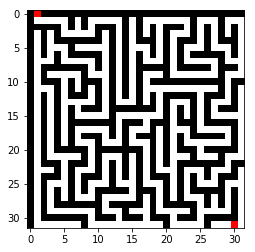

In [136]:
width  = 32
height = 32
maze= np.ones((height,width))
maze[1, 1] = 0

def update_pos(direct, x, y):
    if direct == 0:
        return (x+1,y)
    elif direct == 1:
        return (x, y+1)
    elif direct == 2:
        return (x-1, y)
    else:
        return (x, y - 1)


def carve(x, y):
    direction = random.randint(0,4)
    count = 0
    while count < 4:
        (x1, y1) = update_pos(direction, x, y)
        (x2, y2) = update_pos(direction, x1, y1)
        if x2 > 0 and x2 < width and y2 > 0 and y2 < height:
            if maze[y1,x1] == 1 and maze[y2,x2] == 1:
                maze[y1, x1] = 0
                maze[y2, x2] = 0
                carve(x2, y2)
        count = count + 1
        direction = (direction + 1) % 4

from PIL import ImageDraw

def writeImage(a, fn):
    out = PIL.Image.new('RGB', a.shape, (255,255,255))
    d = ImageDraw.Draw(out)

    (height, width) = a.shape
    for x in range(height):
        for y in range(width):
            if a[y,x] == 0:
                d.point([x,y], fill=(255,255,255))
            else:
                d.point([x,y], fill=(0,0,0))
    d.point([1,0], fill=(255,0,0))
    d.point([width - 2, height - 1], fill=(255,0,0))
    return out

carve(1,1)
maze[0,1] = 0 
maze[height - 1, width - 2] = 0

im = PIL.Image.fromarray(maze)
out = writeImage(maze, "foo")
P.imshow(out)


### Loading the Inception model graph

Run the following cell to download the network. Alternatively, the pretrained network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). Unpack the tensorflow_inception_graph.pb file from the archive and set its path to model_fn variable.

In [137]:
# Use either wget or curl depending on your OS.
if not os.path.exists('inception_v3.ckpt'):
  #!wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
  !curl -O http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
  !tar -xvzf inception_v3_2016_08_28.tar.gz

ckpt_file = './inception_v3.ckpt'

### Adding a single logit tensor for which we want to compute the mask

In [138]:
graph = tf.Graph()

with graph.as_default():
  images = tf.placeholder(tf.float32, shape=(None, 320, 320, 3))

  with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
    _, end_points = inception_v3.inception_v3(images, is_training=False, num_classes=1001)
    
    # Restore the checkpoint
    sess = tf.Session(graph=graph)
    saver = tf.train.Saver()
    saver.restore(sess, ckpt_file)
    
  # Construct the scalar neuron tensor.
  logits = graph.get_tensor_by_name('InceptionV3/Logits/SpatialSqueeze:0')
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[0][neuron_selector]
    
  # Construct tensor for predictions.
  prediction = tf.argmax(logits, 1)


INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt


float64
(320, 320, 3)
Prediction class for maze: 647


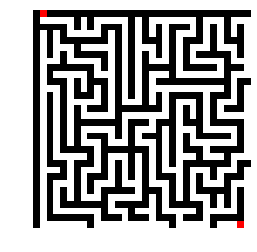

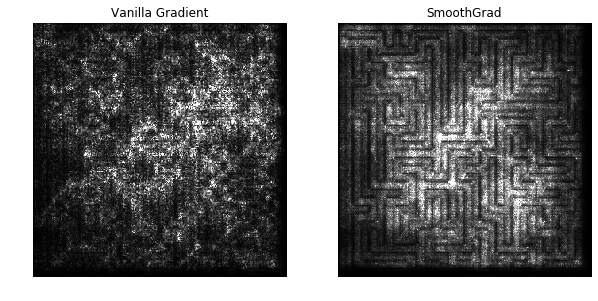

In [139]:
# Load the image
maze = resize(out, 320)

print(maze.dtype)
print(maze.shape)
# Show the image
ShowImage(maze)

# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = saliency.GradientSaliency(graph, sess, y, images)

prediction_class = sess.run(prediction, feed_dict = {images: [maze]})[0]
print("Prediction class for maze:", prediction_class)
# Compute the vanilla mask and the smoothed mask.
#vanilla_mask_3d = gradient_saliency.GetMask(maze, feed_dict = {neuron_selector: prediction_class})
#smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(maze, feed_dict = {neuron_selector: prediction_class})
vanilla_mask_3d = gradient_saliency.GetMask(maze, feed_dict = {neuron_selector: prediction_class})
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(maze, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

### Vanilla Gradient & SmoothGrad

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


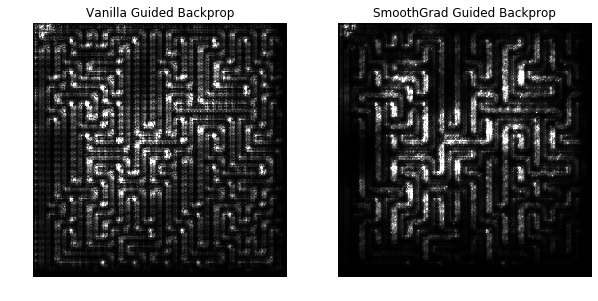

In [140]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
# NOTE: GuidedBackprop creates a copy of the given graph to override the gradient.
# Don't construct too many of these!
guided_backprop = saliency.GuidedBackprop(graph, sess, y, images)

# Compute the vanilla mask and the smoothed mask.
vanilla_guided_backprop_mask_3d = guided_backprop.GetMask(
  maze, feed_dict = {neuron_selector: prediction_class})
smoothgrad_guided_backprop_mask_3d = guided_backprop.GetSmoothedMask(
  maze, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_guided_backprop_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_guided_backprop_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Guided Backprop', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad Guided Backprop', ax=P.subplot(ROWS, COLS, 2))

## Integrated Gradients & SmoothGrad

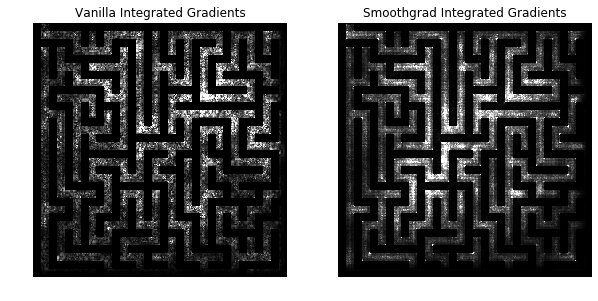

In [141]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
integrated_gradients = saliency.IntegratedGradients(graph, sess, y, images)

# Baseline is a black image.
baseline = np.zeros(maze.shape)
baseline.fill(-1)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  maze, feed_dict = {neuron_selector: prediction_class}, x_steps=25, x_baseline=baseline)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  maze, feed_dict = {neuron_selector: prediction_class}, x_steps=25, x_baseline=baseline)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

# Find most salient point in original maze 

3 most salient points in actual maze:  [[9, 21], [17, 13], [8, 21]]


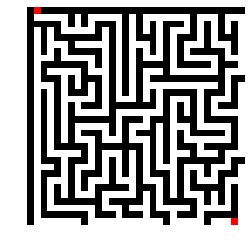

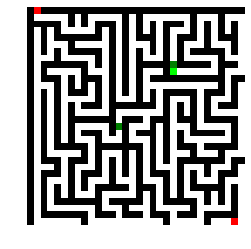

In [142]:
import pickle
import numpy as np

maze_salient = smoothgrad_mask_grayscale
maze_original = resize(out, 32)
 
d = 10.
def order_saliency(maze_salient,d):
    d = int(d)
    X, Y = maze_salient.shape
    sum_list = []
    sumIdx_list = []
    idx = 0
 
    for i in range(X-d):
        for j in range(Y-d):
            sum_list.append((np.sum(maze_salient[i:i+d,j:j+d]),idx))
            idx += 1
            sumIdx_list.append((i,j))
    sumIdx_list = np.array(sumIdx_list)
    sum_list = np.array(sum_list)
 
    sum_list = sum_list[sum_list[:,0].argsort()]
    sum_list = sum_list[::-1] 
    
    max_indx = []
    for i in sum_list[:,1]:
        max_indx.append(sumIdx_list[int(i)])
    max_indx = np.stack(max_indx, axis=0 )
 
    return sum_list[:,0], max_indx
 
# k=3 
# k_sum_list, k_max_indx = order_saliency(maze_salient,d,k)
# print("{} max sums: ".format(k), k_sum_list)
# print("Indices with the {} max sum: ".format(k), k_max_indx)
 
# max_sum, max_indx = order_saliency(maze_salient,d,1)
# print("Single max sum: ",max_sum)
# print("Indices of single max sum: ",max_indx)
 
# max_point_idx = np.unravel_index(np.argmax(maze_salient, axis=None), maze_salient.shape)
# print("Single max point: ", max_point_idx)
 
 
'''map to actual picture 32x32'''
def map2actual(maze_salient, maze_original, d, k, visuals=True, unique=True):
    maze_original=maze_original.astype(int)
 
    sum_list, max_indx = order_saliency(maze_salient,d)
    max_indx_actual = (np.around(max_indx, decimals=-1)/d).astype(int)
    
    if unique:
        indexes = np.unique(max_indx_actual, return_index=True, axis=0)[1]
        max_indx_actual = np.stack([max_indx_actual[index] for index in sorted(indexes)])
    k_max_indx_actual = max_indx_actual[:k]
        
    salient_points_original = [None]*k
    for i, salient_point in enumerate(k_max_indx_actual):
        x,y = salient_point
        if np.all(maze_original[x,y]!=1):
            r = np.copy([x,y])
            l = np.copy([x,y])
            u = np.copy([x,y])
            d = np.copy([x,y])
            pos = [r,l,u,d]
            counts = np.zeros(len(pos))
            while np.all(maze_original[r[0],r[1]]!=1) or counts[0]<5:
                r[0] += 1
                counts[0] += 1
            while np.all(maze_original[l[0],l[1]]!=1) or counts[1]<5:
                l[0] -= 1
                counts[1] += 1
            while np.all(maze_original[u[0],u[1]]!=1) or counts[2]<5:
                u[1] += 1
                counts[2] += 1
            while np.all(maze_original[d[0],d[1]]!=1) or counts[3]<5:
                d[1] -= 1
                counts[3] += 1
 
            min_pos_indx = np.argmin(counts)
            min_pos = pos[min_pos_indx]
        else:
            min_pos = [x,y]
        salient_points_original[i] = min_pos
 
    '''mark original maze with salient points'''
    if visuals:
        maze_original_edited = np.copy(maze_original)
        for i, salient_point in enumerate(salient_points_original):
            x,y = salient_point
            maze_original_edited[x,y] = [-1,1*1/(i+1),-1]
 
        ShowImage(maze_original_edited)
 
    return salient_points_original
 
ShowImage(maze_original)
k = 3
salient_points_original = map2actual(maze_salient, maze_original, d, k)
print("{} most salient points in actual maze: ".format(k), salient_points_original)

# Maze Solver

[[9, 21], [17, 13], [8, 21]]
(492, 2)
True


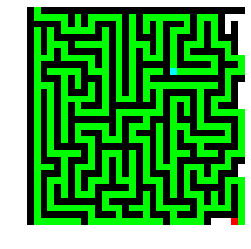

In [143]:
def adapt_maze(maze):
    x,y,z = maze.shape
    adapted_maze = np.copy(maze[:,:,0])
    adapted_maze[x - 1, y - 2] = 2
    adapted_maze[adapted_maze==1] = 0
    adapted_maze[adapted_maze==-1] = 1
    return adapted_maze

maze = adapt_maze(maze_original)

def search(grid, x, y, sol):
    if grid[x][y] == 2:
        return (True, sol)
    elif grid[x][y] == 1:
        return (False, sol)
    elif grid[x][y] == 3:
        return (False, sol)
    
    sol.append((x,y))
    # mark as visited
    grid[x][y] = 3

    # explore neighbors clockwise starting by the one on the right
    if (x < len(grid)-1 and search(grid,x+1,y,sol)[0]):
        sol = search(grid,x+1,y,sol)[1]
        return (True, sol)
    elif (y > 0 and search(grid,x, y-1,sol)[0]):
        sol = search(grid,x, y-1,sol)[1]
        return (True, sol)
    elif (x > 0 and search(grid,x-1, y,sol)[0]):
        sol = search(grid,x-1, y,sol)[1]
        return (True, sol)
    elif (y < len(grid)-1 and search(grid,x, y+1,sol)[0]):
        sol = search(grid,x, y+1,sol)[1]
        return (True, sol)

    return (False,sol)

sol = search(maze, 0, 1, [])[1]
solution = np.copy(maze_original)
for i,j in sol:
    solution[i,j] = [-1,1,-1]


print(salient_points_original)

def check_sol(sol, salient_pts):
    for (xs, ys) in salient_points_original:
        solution[xs,ys] = [-1,1,1]
        for (x,y) in sol:
            if (x == xs and y == ys):
                return True
    return False

# Remove cycles from sol
sol = np.array(sol)
print(sol.shape)
print(check_sol(sol, salient_points_original))

ShowImage(solution)